# Beat-Upbeat Ratio Distributions

## Import dependencies, set constants etc.

In [119]:
import warnings

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import scipy.signal as signal
import statsmodels.formula.api as smf
from sklearn.mixture import GaussianMixture
from statsmodels.tools.sm_exceptions import ConvergenceWarning

from src import utils
import src.visualise.visualise_utils as vutils
from src.features.features_utils import FeatureExtractor

In [120]:
# These variables are used for the optimization process
SEED = 42
N_FOLDS = 5
N_JOBS = -1
N_BOOT = 999

In [121]:
# Upper and lower bounds to use when thresholding BURs
BUR_UPPER = 4.0
BUR_LOWER = 0.25

In [122]:
# Set the seed in NumPy for consistent results across function calls
np.random.seed(SEED)

## Load in data
We start by loading in the data we extracted from our `corpus_chronology` in `src\features\extract_features.py`. This gives us a list of `FeatureExtractor` classes (defined in `src\features\features_utils.py`).

In [123]:
features: list[FeatureExtractor] = utils.unserialise_object(fr'{utils.get_project_root()}\models\extracted_features_corpus_chronology')

In [124]:
res = []
# Iterate through each track
for track in features:
    # Iterate through each instrument
    for instr in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys():
        # Iterate through each BUR by that instrument
        for bur in track.BURs[instr].bur['burs'].dropna().to_list():
            # Append a new dictionary
            res.append(dict(mbz_id=track.metadata[instr]['mbz_id'], bur=np.log2(bur), instrument=instr, tempo=track.metadata[instr]['tempo'], bandleader=track.metadata[instr]['pianist']))
burs = pd.DataFrame(res)

## Clean data
We drop BUR values lower than 0.25 and higher than 4 (see Corcoran & Frieler, 2021)

In [125]:
burs = burs[(burs['bur'] > np.log2(BUR_LOWER)) & (burs['bur'] < np.log2(BUR_UPPER))]

In [126]:
burs.groupby('instrument')['bur'].mean()

instrument
bass     0.056211
drums    0.721039
piano    0.268612
Name: bur, dtype: float64

Now we order our dataframe so that the instruments are in the correct order (piano -> bass -> drums)

In [127]:
burs = (
    burs.set_index('instrument')
    .loc[utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys()]
    .reset_index(drop=False)
)

## Plot the average BUR per instrument

In [128]:
class BarPlotBUR(vutils.BasePlot):
    BURS_WITH_IMAGES = [1, 2]
    BAR_KWS = dict(
        dodge=False, edgecolor=vutils.BLACK, errorbar=('ci', 95),
        lw=vutils.LINEWIDTH, seed=42, capsize=0.1, width=0.8,
        ls=vutils.LINESTYLE, estimator=np.mean,
        errcolor=vutils.BLACK, zorder=1,
        hue_order=utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys(),
        palette=vutils.RGB, alpha=0.8
    )

    def __init__(self, bur_df, **kwargs):
        self.corpus_title = 'corpus_chronology'
        super().__init__(figure_title=fr'bur_plots\barplot_mean_bur_{self.corpus_title}', **kwargs)
        self.df = bur_df
        self.fig, self.ax = plt.subplots(nrows=1, ncols=1, figsize=(vutils.WIDTH / 2, vutils.WIDTH / 2))

    def _create_plot(self):
        sns.barplot(data=self.df, x='instrument', y='bur', **self.BAR_KWS)

    def add_bur_images(self, y):
        """Adds images for required BUR values"""
        # Iterate through all of our BUR values
        for x in self.BURS_WITH_IMAGES:
            # Try and get the image of the notation type for this BUR value
            try:
                img = plt.imread(fr'{utils.get_project_root()}\references\images\bur_notation\bur_{x}.png')
            except FileNotFoundError:
                pass
            # If we can get the image, then yield it to add to our plot
            else:
                yield mpl.offsetbox.AnnotationBbox(
                    mpl.offsetbox.OffsetImage(img, clip_on=False, zoom=0.5), (y, np.log2(x)),
                    frameon=False, xycoords='data', clip_on=False, annotation_clip=False
                 )

    def _format_ax(self):
        # Set the width of the edges and ticks
        for artist in self.add_bur_images(y=2.65):
            self.ax.add_artist(artist)
        for hatch, bar in zip(vutils.HATCHES, self.ax.patches):
            bar.set_hatch(hatch)
        self.ax.grid(zorder=0, axis='y', **vutils.GRID_KWS)
        plt.setp(self.ax.spines.values(), linewidth=vutils.LINEWIDTH, color=vutils.BLACK)
        self.ax.tick_params(axis='both', width=vutils.TICKWIDTH, color=vutils.BLACK)
        self.ax.set(
            ylabel='Mean ${Log_2}$ BUR',
            xticklabels=[i.title() for i in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys()],
            xlabel='Instrument',
            ylim=(-0.1, 1.1),
            yticks=[np.log2(i) for i in self.BURS_WITH_IMAGES]
        )

BarPlotBUR(burs).create_plot()

## Compute the KDE and extract peaks

In [129]:
def get_peaks(data, len_data: int = 1000, **kwargs) -> np.ndarray:
    """Fits a kernel-density estimate to BUR data and extracts BUR peaks"""
    # Fit the actual KDE to the data, using the default parameters
    kde = stats.gaussian_kde(data.T, bw_method='silverman')
    # Create a linear space of integers ranging from our lowest to our highest BUR
    data_plot = np.linspace(data.min(), data.max(), len_data)[:, np.newaxis]
    # Evaluate the KDE on our linear space of integers
    kde_eval = kde.evaluate(data_plot.T)
    # Find the peaks from our fitted KDE
    peaks, _ = signal.find_peaks(kde_eval, **kwargs)
    # Return the sorted peaks from our KDE: this will be an array of BUR values
    return np.sort(data_plot[peaks].flatten())

In [130]:
def bootstrap_peaks(data: np.array, actual_peaks: np.array, tol: float = 0.5) -> dict:
    """Bootstrap confidence intervals for an array of peaks"""
    # We create a dictionary with lists for storing our bootstrapped peaks
    boot_res = {pe: [] for pe in actual_peaks}
    # We perform a few operations here, so we don't have to re-do them every loop
    size = len(data)
    data = data.flatten()
    # For every bootstrapped sample
    for i_ in range(1):
        print(i_)
        # Set the random seed
        np.random.seed(i_)
        # Take a random sample of our BURs, with replacement, and reshape
        boot = np.random.choice(data, replace=True, size=size).reshape(-1, 1)
        # Get the peaks for our bootstrapped sample
        boot_peaks = set(get_peaks(boot))
        # Iterate through the actual peaks of our BURs
        for peak in actual_peaks:
            # Try and find the closest value in our bootstrapped set
            try:
                closest_peak = min(boot_peaks, key=lambda x: abs(x - peak))
            # If we've run out of bootstrapped peaks, break out and finish this sample early
            except ValueError:
                break
            else:
                # If the distance between our actual peak and the nearest bootstrapped peak exceeds our threshold
                if abs(closest_peak - peak) > tol:
                    # Then continue on to the next actual peak, without matching
                    continue
                else:
                    # Otherwise, match our actual peak with this closest peak and remove it from the set
                    boot_res[peak].append(closest_peak)
                    boot_peaks.remove(closest_peak)
    # Return a dictionary with
    return {k: [np.nanpercentile(v, 5), np.nanpercentile(v, 95)] for k, v in boot_res.items()}

In [131]:
res_ = []
for instr, grp in burs.groupby('instrument', sort=False):
    X = grp['bur'].to_numpy().reshape(-1, 1)
    grp_peaks = get_peaks(X)
    ci_peaks = bootstrap_peaks(X, grp_peaks)
    for num, (actual, (low, high)) in enumerate(ci_peaks.items()):
        res_.append(dict(
            instrument=instr,
            peak_num=num,
            peak=actual,
            low=low,
            high=high
        ))
peaks_df = pd.DataFrame(res_)

0
0
0


In [132]:
peaks_df['raw_peak'] = 2 ** peaks_df['peak']
peaks_df

,instrument,peak_num,peak,low,high,raw_peak
0,piano,0,0.334334,0.310310,0.310310,1.260796
1,bass,0,0.010515,0.018505,0.018505,1.007315
2,bass,1,1.081162,1.065182,1.065182,2.115739
3,drums,0,-0.678679,-0.678679,-0.678679,0.624737
4,drums,1,1.163163,1.167167,1.167167,2.239479


## Plot the BUR distribution with density curve and peaks

C:\Users\huwch\AppData\Local\Temp\ipykernel_16640\3476415459.py:60: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axvline(peak['peak'], 0, 1, **self.VLINE_KWS)


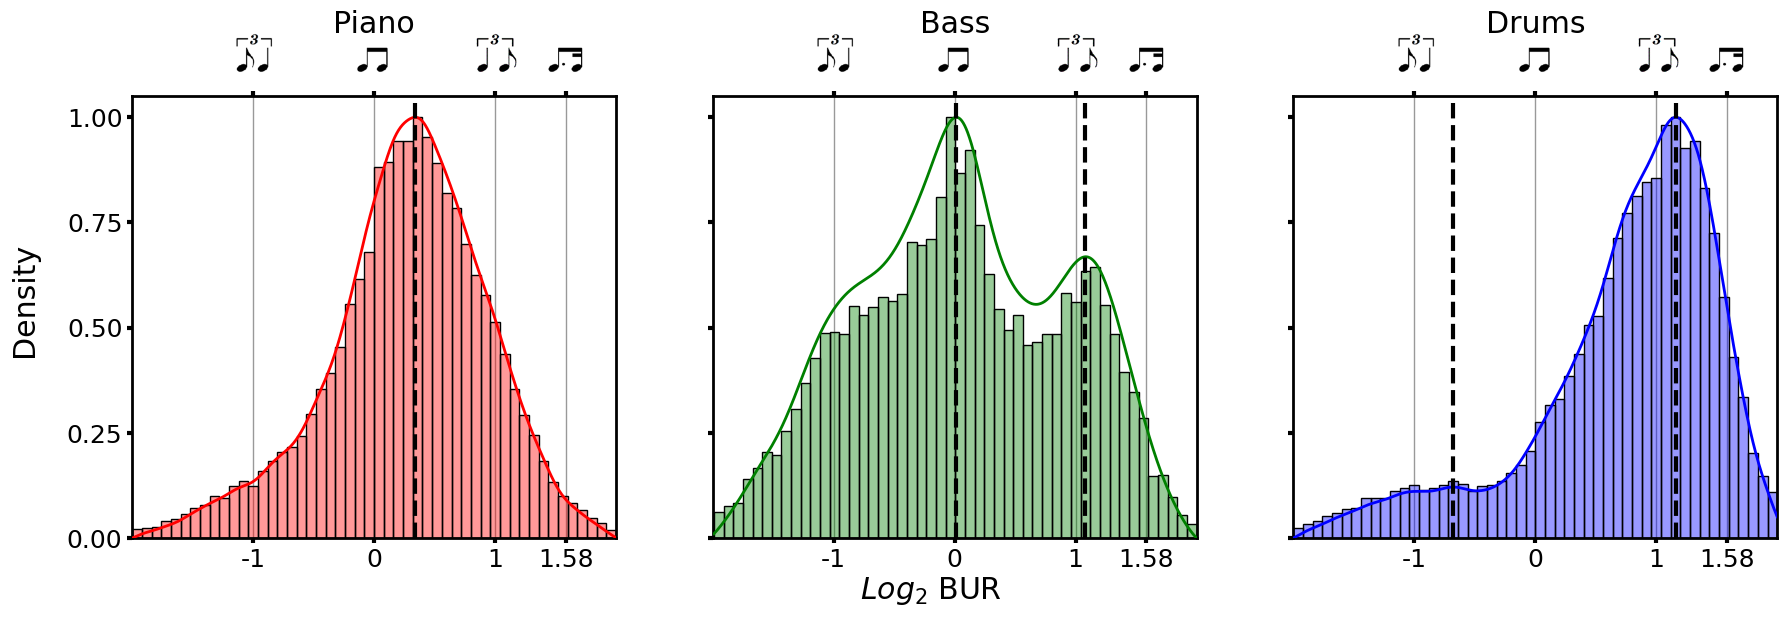

In [137]:
class HistPlotBURByInstrument(vutils.BasePlot):
    BURS_WITH_IMAGES = [0.5, 1, 2, 3]
    HIST_KWS = dict(lw=vutils.LINEWIDTH / 2, ls=vutils.LINESTYLE, zorder=2, align='edge')
    KDE_KWS = dict(linestyle=vutils.LINESTYLE, alpha=1, zorder=3, linewidth=vutils.LINEWIDTH)
    VLINE_KWS = dict(color=vutils.BLACK, linestyle='dashed', alpha=1, zorder=4, linewidth=vutils.LINEWIDTH * 1.5)
    mpl.rcParams.update(mpl.rcParamsDefault)

    def __init__(self, bur: pd.DataFrame, peaks: pd.DataFrame, **kwargs):
        self.corpus_title = 'corpus_chronology'
        super().__init__(figure_title=fr'bur_plots\histplot_bursbyinstrumentgmm_{self.corpus_title}', **kwargs)
        self.bur_df = bur
        self.peak_df = peaks
        self.fig, self.ax = plt.subplots(nrows=1, ncols=3, figsize=(vutils.WIDTH, vutils.WIDTH / 3), sharex=True, sharey=True)

    def add_bur_images(self, y):
        """Adds images for required BUR values"""
        # Iterate through all of our BUR values
        for x in self.BURS_WITH_IMAGES:
            # Try and get the image of the notation type for this BUR value
            try:
                img = plt.imread(fr'{utils.get_project_root()}\references\images\bur_notation\bur_{x}.png')
            except FileNotFoundError:
                pass
            # If we can get the image, then yield it to add to our plot
            else:
                yield mpl.offsetbox.AnnotationBbox(
                    mpl.offsetbox.OffsetImage(img, clip_on=False, zoom=0.5), (np.log2(x), y),
                    frameon=False, xycoords='data', clip_on=False, annotation_clip=False
                 )

    @staticmethod
    def _kde(data, len_data: int = 1000):
        # Fit the actual KDE to the data, using the default parameters
        kde = stats.gaussian_kde(data.T)
        # Create a linear space of integers ranging from our lowest to our highest BUR
        data_plot = np.linspace(data.min(), data.max(), len_data)[:, np.newaxis]
        # Evaluate the KDE on our linear space of integers
        y = kde.evaluate(data_plot.T)
        return data_plot, np.array([(y_ - min(y)) / (max(y) - min(y)) for y_ in y])

    def _create_plot(self) -> None:
        """Creates the histogram and kde plots"""
        for ax, (idx, grp), col in zip(self.ax.flatten(), self.bur_df.groupby('instrument', sort=False), vutils.RGB):
            ax.set_xscale('symlog', base=2)
            ax.grid(zorder=0, axis='x', **vutils.GRID_KWS)
            heights, edges = np.histogram(grp['bur'], bins=vutils.N_BINS)
            heights = heights / max(heights)
            # Plot the normalized histogram
            self.HIST_KWS.update(dict(x=edges[:-1], height=heights, width=np.diff(edges)))
            ax.bar(fc=col, edgecolor='None', alpha=vutils.ALPHA, **self.HIST_KWS)
            ax.bar(fc='None', edgecolor=vutils.BLACK, alpha=1, **self.HIST_KWS)
            # # Plot the kde
            x, y = self._kde(grp['bur'])
            ax.plot(x, y, color=col, label=f'{idx.title()}\n({len(grp)})', **self.KDE_KWS)
            self._add_peaks(ax, idx)

    def _add_peaks(self, ax, ins):
        ps = self.peak_df[self.peak_df['instrument'] == ins]
        for _, peak in ps.iterrows():
            ax.axvline(peak['peak'], 0, 1, **self.VLINE_KWS)

    def _format_ax(self) -> None:
        """Formats axis-level properties"""
        # Add images for each BUR value we want to plot
        hands, labs = [], []
        for ax, name in zip(self.ax.flatten(), utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys()):
            for artist in self.add_bur_images(y=1.15):
                ax.add_artist(artist)
            ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
            ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
            ax.set(xticks=[np.log2(i) for i in self.BURS_WITH_IMAGES], xticklabels=[-1, 0, 1, 1.58], xlim=(np.log2(BUR_LOWER), np.log2(BUR_UPPER)), xlabel='', ylabel='', yticks=np.linspace(0, 1, 5))
            ax.set_title(name.title(), y=1.125)
            plt.setp(ax.spines.values(), linewidth=vutils.LINEWIDTH)
            ax.tick_params(axis='both', top=True, bottom=True, labeltop=False, labelbottom=True, width=vutils.TICKWIDTH)
            hand, lab = ax.get_legend_handles_labels()
            hands.extend(hand)
            labs.extend(lab)
        # self.fig.legend(
        #     hands, labs, frameon=False, ncol=1, markerscale=vutils.MARKERSCALE,
        #     title='Instrument\n($n$BUR)', fontsize=vutils.FONTSIZE, bbox_to_anchor=(1, 0.75)
        # )

    def _format_fig(self) -> None:
        """Formats figure-level properties"""
        self.fig.supxlabel('${Log_2}$ BUR')
        self.fig.supylabel('Density', x=0.01)
        self.fig.subplots_adjust(left=0.075, bottom=0.12, right=0.95, top=0.825)

HistPlotBURByInstrument(burs, peaks_df).create_plot()
plt.show()

## Create GMMs using given number of components

In [117]:
for instr in ['bass', 'drums']:
    data = peaks_df[peaks_df['instrument'] == instr]
    peaks = data['peak'].to_numpy().reshape(-1, 1)
    n_components = len(data)
    gm = GaussianMixture(
        random_state=42,
        n_components=n_components,
        means_init=peaks
    )
    gm.fit(burs[burs['instrument'] == instr]['bur'].to_numpy().reshape(-1, 1))
    means = gm.means_.flatten()
    means_init = gm.means_init.flatten()
    weights = gm.weights_
    print(gm.means_.flatten(), means_init, weights)

[-0.34517166  1.04498657] [0.01051499 1.08116154] [0.71126845 0.28873155]
[-0.42768708  1.03950669] [-0.67867868  1.16316316] [0.21705932 0.78294068]


## Model average tempo vs BUR

In [108]:
average = burs.groupby(['instrument', 'mbz_id']).agg(dict(bur=['mean', 'count'], tempo='median', bandleader='first')).reset_index(drop=False)
average.columns = ['_'.join(col).strip() for col in average.columns.values]
average = average[average['bur_count'] > 15]
print(average)

    instrument_                               mbz_id_  bur_mean  bur_count  \
1          bass  01a2ab5d-dc82-4ffb-b6b4-a33c9933cbcb  0.095254         84   
3          bass  0469f84b-0b9d-4e06-8c82-8d634fd8e8e1 -0.248824        134   
4          bass  058a967c-a132-45e4-ae9d-d5696687e989 -0.377804         19   
5          bass  05bc9ae9-0d39-4176-ba24-0c98a9b5ba53  0.530986         25   
6          bass  0704c6cd-c596-411d-9e29-67c800d34e7d -0.222132         34   
7          bass  079c686e-9916-4665-9c02-07546f33052e  0.777604         19   
10         bass  0cf85e9f-1a5b-4d76-b23b-3b2c340f4f6a -0.004679         73   
12         bass  0ea667bc-a931-439d-adfa-79062ad167d8  0.860434         33   
13         bass  0f5ae211-d04c-4d23-8868-e9b04cd34390  0.128635         31   
18         bass  11fbc4e5-9906-4fe4-9cd9-8f6d3089481c -0.321917        189   
19         bass  1218bb02-baa5-44b3-b84d-02f5e403353a  0.637342         16   
20         bass  1500109e-eaa3-46a1-a2ad-373f7c3c9255  0.621378 

In [109]:
md = smf.mixedlm("bur_mean~tempo_median+C(instrument_, Treatment(reference='piano'))", data=average, groups=average['bandleader_first']).fit(reml=False)
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Mixed Linear Model Regression Results
=================================================================================================
Model:                          MixedLM               Dependent Variable:               bur_mean 
No. Observations:               751                   Method:                           ML       
No. Groups:                     10                    Scale:                            0.0802   
Min. group size:                68                    Log-Likelihood:                   -128.6682
Max. group size:                81                    Converged:                        Yes      
Mean group size:                75.1                                                             
-------------------------------------------------------------------------------------------------
                                                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------------------
Intercept                                              1.005    0.058  17.457 0.000  0.892  1.118
C(instrument_, Treatment(reference='piano'))[T.bass]  -0.273    0.028  -9.777 0.000 -0.327 -0.218
C(instrument_, Treatment(reference='piano'))[T.drums]  0.454    0.023  19.391 0.000  0.408  0.500
tempo_median                                          -0.004    0.000 -15.268 0.000 -0.004 -0.003
Group Var                                              0.008    0.014                            
=================================================================================================

"""

In [115]:
# Variance explained by the fixed effects: we need to use md.predict() with the underlying data to get this
var_fixed = md.predict().var()
# Variance explained by the random effects
var_random = float(md.cov_re.iloc[0])
# Variance of the residuals
var_resid = md.scale
# Total variance of the model
total_var = var_fixed + var_random + var_resid
# Calculate the r2 values and append to the model
print('conditional_r2:', (var_fixed + var_random) / total_var)
print('marginal_r2:', var_fixed / total_var)

conditional_r2: 0.5771841538499208
marginal_r2: 0.5348399487729287


In [116]:
stddev = np.std([v.iloc[0] for v in md.random_effects.values()])
print('stdev of bandleader groups:', stddev)

stdev of bandleader groups: 0.08416712404462894


## Plot average BUR vs tempo

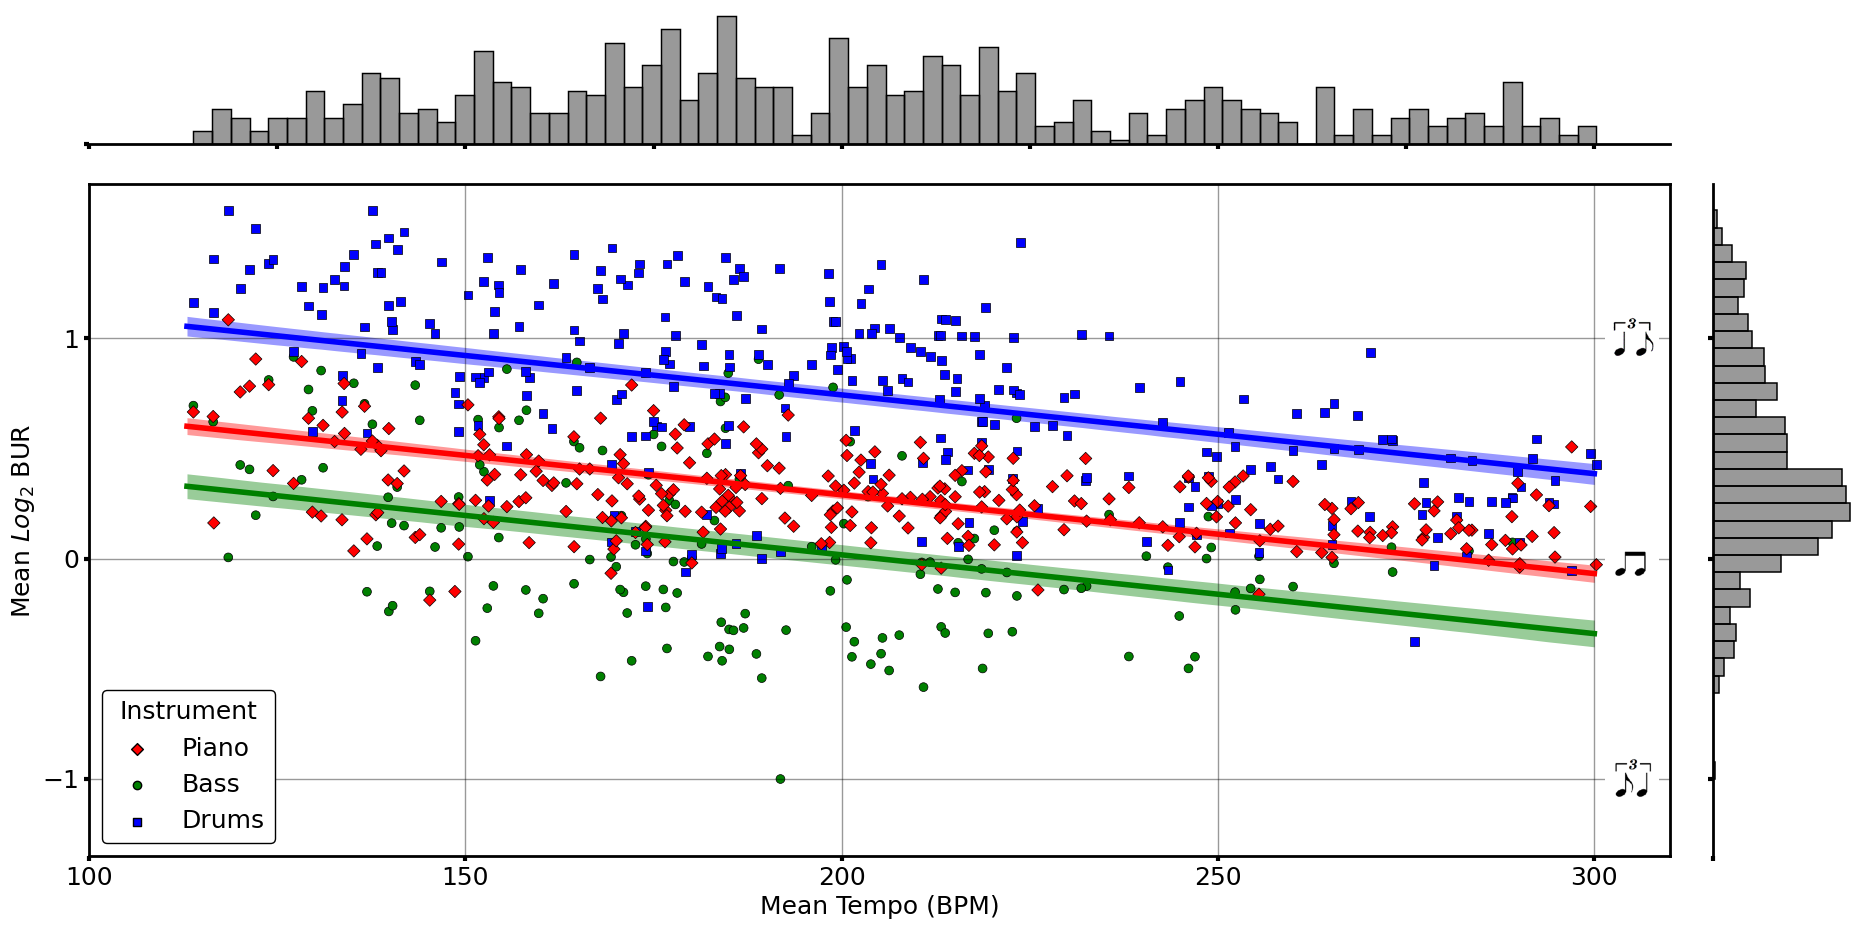

In [114]:
class RegPlotBURTempo(vutils.BasePlot):
    warnings.simplefilter('ignore', ConvergenceWarning)

    BURS_WITH_IMAGES = [0.5, 1, 2]
    LINE_KWS = dict(lw=vutils.LINEWIDTH * 2, ls=vutils.LINESTYLE)
    FILL_KWS = dict(lw=0, ls=vutils.LINESTYLE, alpha=vutils.ALPHA)
    SCATTER_KWS = dict(hue_order=['piano', 'bass', 'drums'], palette=vutils.RGB, markers=['o', 's', 'D'], s=40, edgecolor=vutils.BLACK, zorder=1)
    HIST_KWS = dict(kde=False, color=vutils.BLACK, alpha=vutils.ALPHA, lw=vutils.LINEWIDTH, ls=vutils.LINESTYLE)
    MODEL = "bur_mean~tempo_median+C(instrument_, Treatment(reference='piano'))"

    def __init__(self, bur_df, **kwargs):
        self.corpus_title = 'corpus_chronology'
        super().__init__(figure_title=fr'bur_plots\regplot_burtempo_{self.corpus_title}', **kwargs)
        self.average = bur_df.groupby(['instrument', 'mbz_id']).agg(dict(bur=['mean', 'count'], tempo='median', bandleader='first')).reset_index(drop=False)
        self.average.columns = ['_'.join(col).strip() for col in self.average.columns.values]
        self.average = self.average[self.average['bur_count'] > 15]
        self.md = self._mixedlm(self.average)
        self.fig, self.ax = plt.subplots(nrows=2, ncols=2, gridspec_kw=dict(width_ratios=(11, 1), height_ratios=(1, 5)), figsize=(vutils.WIDTH, vutils.WIDTH / 2))
        self.main_ax = self.ax[1, 0]
        self.marginal_ax = np.array([self.ax[0, 0], self.ax[1, 1]])
        self.ax[0, 1].axis('off')

    def add_bur_images(self, y):
        """Adds images for required BUR values"""
        # Iterate through all of our BUR values
        for x in self.BURS_WITH_IMAGES:
            # Try and get the image of the notation type for this BUR value
            try:
                img = plt.imread(fr'{utils.get_project_root()}\references\images\bur_notation\bur_{x}.png')
            except FileNotFoundError:
                pass
            # If we can get the image, then yield it to add to our plot
            else:
                yield mpl.offsetbox.AnnotationBbox(
                    mpl.offsetbox.OffsetImage(img, clip_on=False, zoom=0.5), (y, np.log2(x)),
                    frameon=False, xycoords='data', clip_on=False, annotation_clip=False
                 )

    def _mixedlm(self, model_data: pd.DataFrame):
        return smf.mixedlm(self.MODEL, data=model_data, groups=model_data['bandleader_first']).fit(reml=False)

    def _get_line(self, model):
        intercept = model.params['Intercept']
        tempo = model.params['tempo_median']
        is_bass = (model.params["C(instrument_, Treatment(reference='piano'))[T.bass]"] * 1)
        is_drums = (model.params["C(instrument_, Treatment(reference='piano'))[T.drums]"] * 1)
        is_piano = 0
        for i in range(int(np.floor(self.average['tempo_median'].min())), int(np.ceil(self.average['tempo_median'].max()))):
            for instr_, add_ in zip(utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys(), [is_piano, is_bass, is_drums]):
                yield dict(tempo=i, instr=instr_, bur=intercept + (tempo * i) + add_)

    def _format_bootstrap_lines(self, boot_lines):
        big = pd.concat([pd.DataFrame(self._get_line(boot)) for boot in boot_lines], axis=1)
        for idx, row in big.iterrows():
            yield dict(
                tempo=row['tempo'].iloc[0],
                instr=row['instr'].iloc[0],
                low=np.percentile(row['bur'], 5),
                high=np.percentile(row['bur'], 95)
            )

    def _create_plot(self):
        line_df = pd.DataFrame(self._get_line(self.md))
        boot_mds = [self._mixedlm(self.average.sample(frac=1, replace=True, random_state=i)) for i in range(999)]
        boot_lines = pd.DataFrame(self._format_bootstrap_lines(boot_mds))
        for instr_, col_ in zip(utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys(), vutils.RGB):
            temp_ = line_df[line_df['instr'] == instr_]
            temp_boot_ = boot_lines[boot_lines['instr'] == instr_]
            self.main_ax.plot(temp_['tempo'], temp_['bur'], color=col_, **self.LINE_KWS)
            self.main_ax.fill_between(temp_boot_['tempo'], temp_boot_['low'], temp_boot_['high'], color=col_, **self.FILL_KWS)
        sns.scatterplot(data=self.average, x='tempo_median', y='bur_mean', style='instrument_', ax=self.main_ax, hue='instrument_', **self.SCATTER_KWS )
        sns.histplot(data=self.average, x='tempo_median', ax=self.marginal_ax[0], bins=int(vutils.N_BINS * 1.5),  **self.HIST_KWS)
        sns.histplot(data=self.average, y='bur_mean', ax=self.marginal_ax[1], bins=int(vutils.N_BINS / 1.5),  **self.HIST_KWS)

    def _format_ax(self):
        for artist in self.add_bur_images(y=305):
            self.main_ax.add_artist(artist)
        self.marginal_ax[0].spines[['left', 'right', 'top']].set_visible(False)
        self.marginal_ax[0].set(xlabel='', ylabel='', yticks=[0], yticklabels=[''], xticklabels=[], xlim=(100, 310))
        self.marginal_ax[1].spines[['bottom', 'right', 'top']].set_visible(False)
        self.marginal_ax[1].set(xlabel='', ylabel='', xticks=[0], xticklabels=[''], yticklabels=[], ylim=(-1.35, 1.7), yticks=[-1, 0, 1])
        for a in [self.main_ax, *self.marginal_ax.flatten()]:
            plt.setp(a.spines.values(), linewidth=vutils.LINEWIDTH)
            a.tick_params(axis='both', bottom=True, width=vutils.TICKWIDTH)
        self.main_ax.grid(visible=True, axis='both', which='major', zorder=0, **vutils.GRID_KWS)
        hand, _ = self.main_ax.get_legend_handles_labels()
        for ha in hand:
            ha.set_edgecolor(vutils.BLACK)
        self.main_ax.get_legend().remove()
        self.main_ax.legend(hand, ['Piano', 'Bass', 'Drums'], loc='lower left', title='Instrument', frameon=True, framealpha=1, edgecolor=vutils.BLACK)
        self.main_ax.set(xticks=[100, 150, 200, 250, 300], yticks=[-1, 0, 1], xlim=(100, 310), xlabel='Mean Tempo (BPM)', ylabel='Mean ${Log_2}$ BUR', ylim=(-1.35, 1.7))

    def _format_fig(self):
        self.fig.subplots_adjust(left=0.05, right=0.99, top=0.99, bottom=0.09, hspace=0.1, wspace=0.05)

RegPlotBURTempo(burs).create_plot()
plt.show()